In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     

# first install tigramite developer branch from https://github.com/jakobrunge/tigramite.git
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.causal_effects import CausalEffects
from tigramite.lpcmci import LPCMCI

import statsmodels
# Seaborn for nice scatter plots
import seaborn as sns
import pandas as pd

In [6]:

from tigramite.independence_tests.robust_parcorr import RobustParCorr

In [2]:
# Z_t = Z_t-1 (r-r*Z_t-1 + sigma*eta_t) mod 1
# X_t = X 

def rand_noise(n): 
    return np.random.normal(0,0.01,n)

def func_z(z_1,noise, r= 4):
    return  z_1 * (r- r* z_1 +  noise)  % 1

def func_x(x_1, z_1, noise, r = 4):
    return x_1* (r-r*x_1 - z_1 + noise) % 1

def func_y(y_1, z_1, noise, r = 4):
    return y_1 * (r-r*y_1 - z_1 + noise) % 1

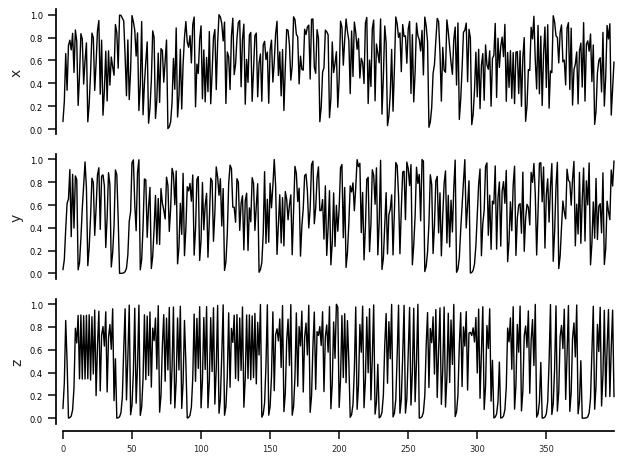

In [10]:
def draw_values(n= 1000):
    vals = []
    i = 0
    noise_x = rand_noise(n)
    noise_z = rand_noise(n)
    noise_y = rand_noise(n)
    z_1 = 7
    x_1 = 8
    y_1 = 9
    while i < n:
        z_t = func_z(z_1, noise_z[i])
        x_t = func_x(x_1,z_1, noise_x[i]) 
        y_t = func_y(y_1,z_1, noise_y[i]) 
        vals.append([ x_t, y_t, z_t,])
        z_1 = z_t
        x_1 = x_t
        y_1 = y_t
        i += 1

    return np.array(vals)
var_names=["x", "y", "z"]
data = draw_values(400)
dataframe = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe); plt.show()

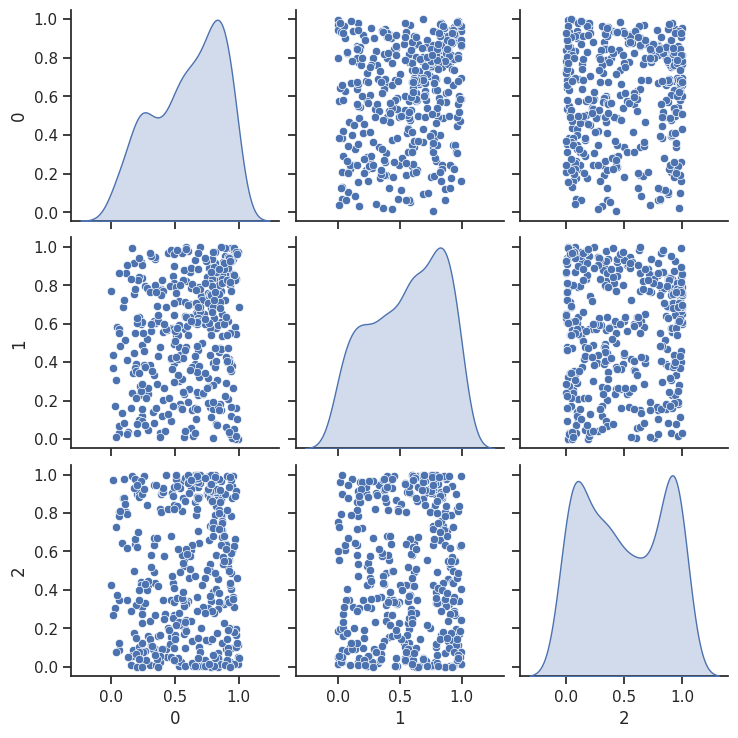

In [11]:
sns.set(style="ticks")
df = pd.DataFrame(data)
sns.pairplot(df, diag_kind = 'kde'); plt.show()

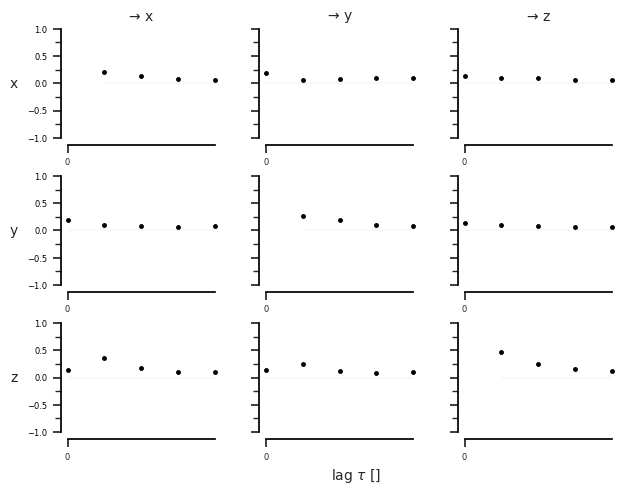

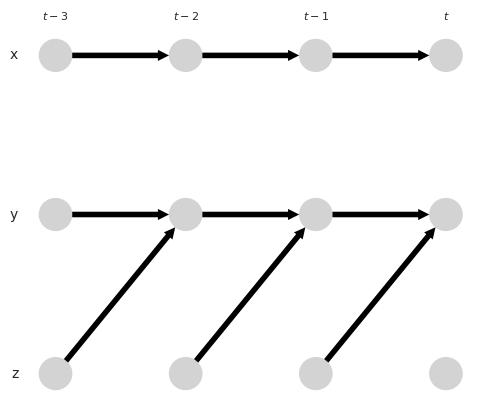

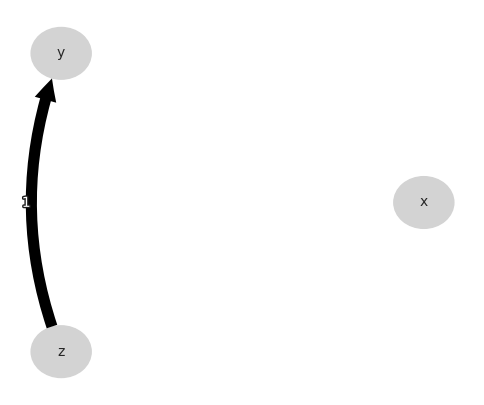

In [14]:
#ci_test = CMIknn() #(significance='analytic')
#ci_test = RobustParCorr(significance='analytic')
ci_test = GPDC()

pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=ci_test,
    verbosity=0)

correlations = pcmci.get_lagged_dependencies(tau_max=4, val_only=True)['val_matrix']

lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5})

alpha_level = 0.01
tau_max = 2
results = pcmci.run_pcmci(tau_max=tau_max, tau_min=0, alpha_level=alpha_level)
tp.plot_time_series_graph(graph=results['graph'], save_name=None, 
            var_names=var_names, 
                          figsize=(6, 5), 
                        )
tp.plot_graph(graph=results['graph'], save_name=None, 
            var_names=var_names, 
                          figsize=(6, 5), 
                        ); plt.show()